In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('data/melb_data.csv')
data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [7]:
#Drop instances where there is no available price
data.dropna(axis=0, subset=['Price'], inplace=True)

#Keep only categorical features with low cardinality
features = data.drop(['Price'], axis=1)
high_card_cat_features = [cname for cname in features.columns if features[cname].nunique() >= 10 and features[cname].dtype == 'object']

numerical_cols = [cname for cname in features.columns if features[cname].nunique() >= 10 and features[cname].dtype != 'object']
categorical_cols = [cname for cname in features.columns if features[cname].nunique() < 10 and features[cname].dtype == 'object']

used_cols = numerical_cols + categorical_cols

X = features[used_cols]
y = data.Price

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

In [11]:
# Create pipeline
## Preprocess data
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

numerical_transformer = SimpleImputer()
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessing = ColumnTransformer(transformers=[
    ('numerical', numerical_transformer, numerical_cols),
    ('categorical', categorical_transformer, categorical_cols)
]
)

In [15]:
# Define model
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=0)

pipeline = Pipeline(steps=[
    ('pre', preprocessing),
    ('model', model)
])

In [16]:
# Fit model 
pipeline.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('numerical', SimpleImputer(),
                                                  ['Distance', 'Postcode',
                                                   'Bedroom2', 'Car',
                                                   'Landsize', 'BuildingArea',
                                                   'YearBuilt', 'Lattitude',
                                                   'Longtitude',
                                                   'Propertycount']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Type', 'M...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, random_state=0, ...))])

In [17]:
# Predict and compute MAE
from sklearn.metrics import mean_absolute_error

prediction = pipeline.predict(X_valid)

mae = mean_absolute_error(prediction, y_valid)
mae

160896.6195738218

### Improving the model

In [34]:
import numpy as np
def get_score(n_estimators, learning_rate=0.05):
        
    model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, n_jobs=8)
    pipeline = Pipeline(steps=[
        ('pre', preprocessing),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)

    mae = mean_absolute_error(pipeline.predict(X_valid),y_valid)
    return mae
    
n_estimators_range = range(100, 1000, 100)
learning_rate_range = np.arange(0.01,0.15, step=0.02)

results = {(n_estimators, learning_rate): get_score(n_estimators,learning_rate)
           for n_estimators in n_estimators_range for learning_rate in learning_rate_range
          }

Text(0.5, 0, 'n_estimators')

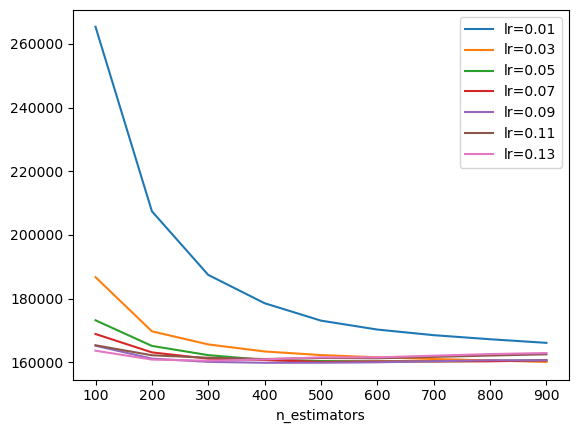

In [35]:
#Plot MAEs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

n_estimators_values = list(n_estimators_range)
learning_rate_values = list(learning_rate_range)

fig = plt.figure()
for lr in learning_rate_values:
    y = [results[(n_estimators,lr)] for n_estimators in n_estimators_values]
    plt.plot(n_estimators_values, y, label=f'lr={lr:.2f}')
plt.legend()
plt.xlabel('n_estimators')


#3d plot
# N_estimators_values, Learning_rate_values = np.meshgrid(n_estimators_values,learning_rate_values)

# Z = np.array(list(results.values())).reshape(len(n_estimators_values), len(Learning_rate_values))

# N_estimators_values_flat = N_estimators_values.flatten()
# Learning_rate_flat = Learning_rate_values.flatten()
# Z_flat = Z.flatten()

# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')

# # Create the scatter plot
# sc = ax.scatter(N_estimators_values_flat, Learning_rate_flat, Z_flat, c=Z_flat, cmap='viridis')

# plt.colorbar(sc, label='Z value')

# ax.set_xlabel('n_estimators')
# ax.set_ylabel('learning rate')
# ax.set_zlabel('MAE')

# plt.show()

In [44]:
#Find best parameters
maes = list(results.values())

min_index = maes.index(min(maes))

n = len(learning_rate_values)
n_index = min_index // n
lr_index = min_index % n

best_n, best_lr = n_estimators_values[n_index], learning_rate_values[lr_index]

print(f'The best parameters are:\nn={best_n}\nlr={best_lr:.2f}')

The best parameters are:
n=400
lr=0.09


In [47]:
my_best_model = XGBRegressor(n_estimators=best_n, learning_rate=best_lr)
pipeline = Pipeline(steps=[
    ('pre', preprocessing),
    ('model', my_best_model)
])
pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_valid)
my_best_mae = mean_absolute_error(predictions,y_valid)
print(f'Best MAE = {my_best_mae:2f}')

Best MAE = 159822.190100


The mean relative prediction error was -3.00313132185832%


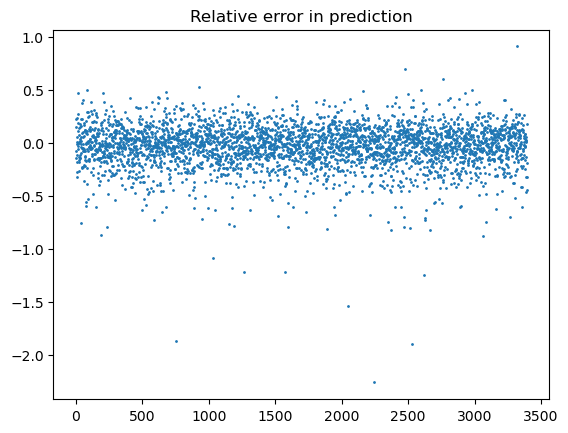

In [60]:
n = len(y_valid)
relative_error = (y_valid - predictions)/y_valid

plt.plot(range(n), relative_error,'o', markersize=1)
plt.title('Relative error in prediction')

print(f'The mean relative prediction error was {relative_error.mean()*100}%')